In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import cv2 as cv
import torch
import torchvision
import os
import logging
import warnings


from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.utils import draw_bounding_boxes
from torchvision import transforms, models, ops
from torchvision.models.detection.image_list import ImageList
from tqdm.notebook import tqdm
from sklearn.metrics import auc

# import pytorch_lightning as pl
# from torchmetrics.detection.mean_ap import MeanAveragePrecision
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

plt.rcParams['figure.constrained_layout.use'] = True

In [ ]:
warnings.filterwarnings('ignore')

logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount= True)
os.chdir('/content/drive/MyDrive/CIS_680_HW_4B')
import torch.optim as optim 

Mounted at /content/drive/


In [ ]:
try:
    from dataset import BuildDataset, BuildDataLoader
    from BoxHead import *
    from utils import *
    from pretrained_models import *
except ModuleNotFoundError:
    pass

# * Load Dataset

In [ ]:
imgs_path = './data/hw3_mycocodata_img_comp_zlib.h5'
masks_path = './data/hw3_mycocodata_mask_comp_zlib.h5'
labels_path = './data/hw3_mycocodata_labels_comp_zlib.npy'
bboxes_path = './data/hw3_mycocodata_bboxes_comp_zlib.npy'
paths = [imgs_path, masks_path, labels_path, bboxes_path]

torch.manual_seed(0)

In [ ]:
paths = [imgs_path, masks_path, labels_path, bboxes_path]
# load the data into data.Dataset
dataset = BuildDataset(paths)

# Standard Dataloaders Initialization
full_size = len(dataset)
train_size = int(full_size * 0.8)
test_size = full_size - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

batch_size = 4
test_build_loader = BuildDataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = test_build_loader.loader()

# 1. Vizualize Ground Truth

In [ ]:
def pretrained_models_680(checkpoint_file, eval=True):
    import torchvision
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False)

    if eval:
        model.eval()

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)

    backbone = model.backbone
    rpn = model.rpn

    if eval:
        backbone.eval()
        rpn.eval()

    rpn.nms_thresh = 0.6
    checkpoint = torch.load(checkpoint_file)

    backbone.load_state_dict(checkpoint['backbone'])
    rpn.load_state_dict(checkpoint['rpn'])

    return backbone, rpn

In [ ]:
pretrained_path='checkpoint680.pth'
with torch.no_grad():
  backbone, rpn = pretrained_models_680(pretrained_path)

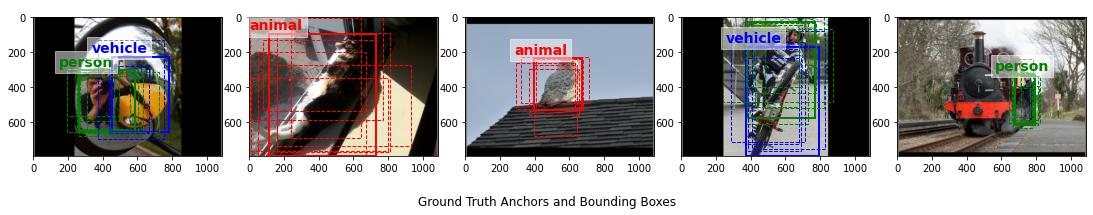

In [ ]:
# Here we keep the top 20, but during training you should keep around 200 boxes from the 1000 proposals
keep_topK = 20

num_plots = 5

head = BoxHead()
annotations = ["vehicle", "person", "animal"]
colors = ['b', 'g', 'r']

fig = plt.figure(figsize=(15, 5))

with torch.no_grad():
    for iter, batch in enumerate(test_loader, 0):
        images = batch['images'].to(device)
        labels = batch['labels']
        bboxes = batch['bbox']

        # Take the features from the backbone
        backout = backbone(images.type(torch.float))

        # The RPN implementation takes as first argument the following image list
        im_lis = ImageList(images, [(800, 1088)] * images.shape[0])

        # Then we pass the image list and the backbone output through the rpn
        rpnout = rpn(im_lis, backout)

        # The final output is
        # A list of proposal tensors: list:len(bz){(keep_topK,4)}
        proposals = [proposal[0:keep_topK, :] for proposal in rpnout[0]]

        # A list of features produces by the backbone's FPN levels: list:len(FPN){(bz,256,H_feat,W_feat)}
        fpn_feat_list = list(backout.values())

        # Create Ground Truth
        tgt_labels, tgt_reg = head.create_ground_truth(proposals, labels, bboxes)

        feature_vectors = head.MultiScaleRoiAlign(fpn_feat_list, proposals)

        img_squeeze = transforms.functional.normalize(images[0].to('cpu'),
                                                            [-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
                                                            [1 / 0.229, 1 / 0.224, 1 / 0.225], inplace=False)
        ax = fig.add_subplot(1, num_plots, iter+1)
        ax.imshow(img_squeeze.permute(1, 2, 0))

        for sample in range(len(labels)):
            box = bboxes[sample]
            label = labels[sample]
            for obj in range(len(label)):            
                rect=patches.Rectangle((box[obj][0], box[obj][1]),
                                       box[obj][2]-box[obj][0],
                                       box[obj][3]-box[obj][1],
                                       fill=False, color=colors[int(label[obj] - 1)], linewidth=2.0)
                ax.add_patch(rect)
                ax.annotate(annotations[int(label[obj]) - 1], (box[obj][0] + 40, box[obj][1] - 50), color=colors[int(label[obj] - 1)], weight='bold', 
                        fontsize=14, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, edgecolor="white"))
        
        class_gt_box = torch.Tensor(tgt_reg)
        proposal_flatten = proposals.copy()
        proposal_flatten = torch.stack(proposal_flatten, dim=0)
        proposal_flatten = proposal_flatten.reshape((-1, proposal_flatten.shape[2]))
        proposals_decoded = output_decoding(class_gt_box.detach().cpu(), proposal_flatten.detach().cpu(), device=device)

        for c, l in zip(proposal_flatten[(tgt_labels>0).flatten(), :].detach().cpu(), tgt_labels[tgt_labels>0].detach().cpu()):
            rect=patches.Rectangle((c[0], c[1]), c[2]-c[0], c[3]-c[1], fill=False, color=colors[int(l - 1)], linestyle='--')
            ax.add_patch(rect)

        if iter == num_plots-1:
            break

    plt.suptitle('Ground Truth Anchors and Bounding Boxes', y=0.2)
    plt.tight_layout(pad=0)
    plt.show()

# 2. Training Loop


In [ ]:
model = BoxHead().to(device)

keep_topK = 200 #For training
optimizer = optim.Adam(model.parameters(), lr = 0.001)
epochs = 20
loss_test_prev = 2.6
train_loss = []
train_class_loss = []
train_regr_loss = []

test_loss = []
test_class_loss = []
test_regr_loss = []
for epoch in range(epochs):
  combined_loss = 0.0
  loss_class = 0.0
  loss_regr = 0.0

  model.train()
  for i, batch in enumerate(train_loader):
    images = batch[0].to(device)
    labels = batch[1]
    bbox = batch[3]

    backout = backbone(images.float())
    im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
    rpnout = rpn(im_lis, backout)

    proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]
    fpn_feat_list= list(backout.values())

    optimizer.zero_grad()

    gt_class_labels, gt_regr = model.create_ground_truth(proposals, labels, bbox)
    feature_vectors = model.MultiScaleRoiAlign(fpn_feat_list, proposals)

    class_logits, box_pred = model.forward(feature_vectors.detach())
    
    loss, loss_c, loss_r = loss, loss_c, loss_r = model.compute_loss(class_logits.to(device), box_pred.to(device), gt_class_labels.to(device), gt_regr.to(device), effective_batch=150)
            
    loss.backward()
    optimizer.step()

    combined_loss += loss.item()
    loss_class += loss_c.item()
    loss_regr += loss_r.item()

    del class_logits, box_pred
    torch.cuda.empty_cache() 

  combined_loss = combined_loss / len(train_loader)
  loss_class = loss_class / len(train_loader)
  loss_regr = loss_regr / len(train_loader)

  train_loss.append(combined_loss)
  train_class_loss.append(loss_class)
  train_regr_loss.append(loss_regr)

  print("Train Loss for epoch "+ str(epoch+1) + ". Total Loss = " + str(combined_loss) + ". Classifier Loss = " + str(loss_class) + ". Regressor Loss = " + str(loss_regr))

  loss_test = 0.0
  loss_class_test = 0.0
  loss_regr_test = 0.0

  with torch.no_grad():
    for j, test_data in enumerate(test_loader):
      model.eval()
      images = test_data[0].to(device)
      labels = test_data[1]
      bbox = test_data[3]

      backout = backbone(images.float())
      im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
      rpnout = rpn(im_lis, backout)

      proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]
      fpn_feat_list= list(backout.values())

      optimizer.zero_grad()

      gt_class_labels, gt_regr = model.create_ground_truth(proposals, labels, bbox)
      feature_vectors = model.MultiScaleRoiAlign(fpn_feat_list, proposals)

      class_logits, box_pred = model.forward(feature_vectors.detach())

      loss, loss_c, loss_r = model.compute_loss(class_logits.to(device), box_pred.to(device), gt_class_labels.to(device), gt_regr.to(device), effective_batch=150)
      
      loss_test += loss.item()
      loss_class_test += loss_c.item()
      loss_regr_test += loss_r.item()
    
    loss_test = loss_test / len(test_loader)
    loss_class_test = loss_class_test / len(test_loader)
    loss_regr_test = loss_regr_test / len(test_loader)    

    test_loss.append(loss_test)
    test_class_loss.append(loss_class_test)
    test_regr_loss.append(loss_regr_test)

    if loss_test < loss_test_prev:
        loss_test_prev = loss_test
        torch.save(model.state_dict(), './val/model_trained_val.pth')

        np.save('./val/train_loss_val.npy', np.array(train_loss))
        np.save('./val/train_class_loss_val.npy', np.array(train_class_loss))
        np.save('./val/train_regr_loss_val.npy', np.array(train_regr_loss))
        np.save('./val/test_loss_val.npy', np.array(test_loss))
        np.save('./val/test_class_loss_val.npy', np.array(test_class_loss))
        np.save('./val/test_regr_loss_val.npy', np.array(test_regr_loss))


    print("Test Loss for epoch "+ str(epoch+1) + ". Total Loss = " + str(loss_test) + ". Classifier Loss = " + str(loss_class_test) + ". Regressor Loss = " + str(loss_regr_test))
      

print('Finished Training')



Train Loss for epoch 1. Total Loss = 2.961348065008248. Classifier Loss = 2.1981824040412903. Regressor Loss = 0.7631656574071093
Test Loss for epoch 1. Total Loss = 2.72135328628668. Classifier Loss = 2.16945616791888. Regressor Loss = 0.5518971198215717
Train Loss for epoch 2. Total Loss = 2.6342012909616117. Classifier Loss = 2.1468343569527724. Regressor Loss = 0.48736693829891325
Test Loss for epoch 2. Total Loss = 2.613174657269222. Classifier Loss = 2.1661245819272064. Regressor Loss = 0.4470500833831909
Train Loss for epoch 3. Total Loss = 2.523978462810721. Classifier Loss = 2.118929156939432. Regressor Loss = 0.40504930575719106
Test Loss for epoch 3. Total Loss = 2.5608816081430854. Classifier Loss = 2.1562755533107896. Regressor Loss = 0.4046060557863334
Train Loss for epoch 4. Total Loss = 2.4606939086870248. Classifier Loss = 2.1008880561927925. Regressor Loss = 0.35980585531244597
Test Loss for epoch 4. Total Loss = 2.5768091754942404. Classifier Loss = 2.153013973337848

In [ ]:
torch.save(model.state_dict(), './model_trained_best.pth')

np.save('train_loss.npy', np.array(train_loss))
np.save('train_class_loss.npy', np.array(train_class_loss))
np.save('train_regr_loss.npy', np.array(train_regr_loss))
np.save('test_loss.npy', np.array(test_loss))
np.save('test_class_loss.npy', np.array(test_class_loss))
np.save('test_regr_loss.npy', np.array(test_regr_loss))

### Train and Test Loss



Text(0.5, 1.0, 'Training and Testing Loss vs Epoch')

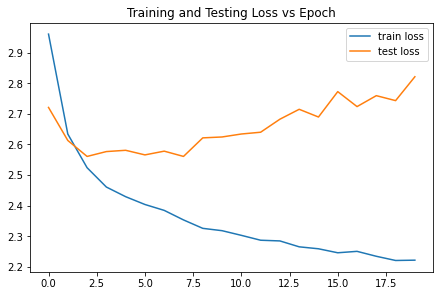

In [ ]:
plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label='test loss')
plt.legend()
plt.title('Training and Testing Loss vs Epoch')

### Classification Loss

Text(0.5, 1.0, 'Training and Testing Class Loss vs Epoch')

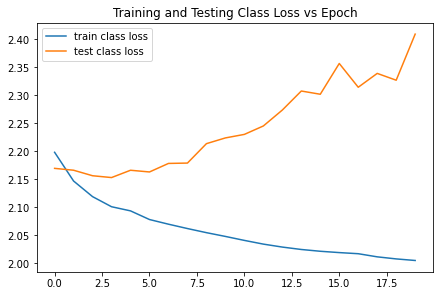

In [ ]:
plt.plot(train_class_loss, label='train class loss')
plt.plot(test_class_loss, label='test class loss')
plt.legend()
plt.title('Training and Testing Class Loss vs Epoch')

### Regression Loss

Text(0.5, 1.0, 'Training and Testing Regressor Loss vs Epoch')

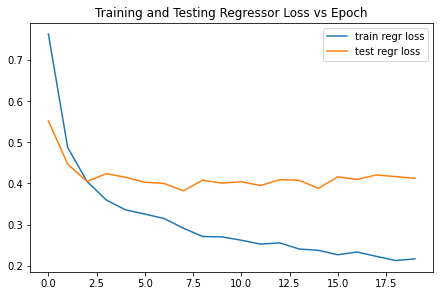

In [ ]:
plt.plot(train_regr_loss, label='train regr loss')
plt.plot(test_regr_loss, label='test regr loss')
plt.legend()
plt.title('Training and Testing Regressor Loss vs Epoch')

# * Load Test Data

In [ ]:
paths = [imgs_path, masks_path, labels_path, bboxes_path]
# load the data into data.Dataset
dataset = BuildDataset(paths)

# Standard Dataloaders Initialization
full_size = len(dataset)
train_size = int(full_size * 0.8)
test_size = full_size - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

batch_size = 1
test_build_loader = BuildDataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=0)
test_loader = test_build_loader.loader()

# 3. Top 20 Proposals

In [ ]:
MODEL_PATH = './model_trained_best.pth'
model = BoxHead().to(device)
model.load_state_dict(torch.load(MODEL_PATH)['model_state_dict'])
model.eval()

BoxHead(
  (celoss): CrossEntropyLoss()
  (smoothl1): SmoothL1Loss()
  (intermediate): Sequential(
    (0): Linear(in_features=12544, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
  )
  (classifier): Linear(in_features=1024, out_features=4, bias=True)
  (regressor): Linear(in_features=1024, out_features=12, bias=True)
)

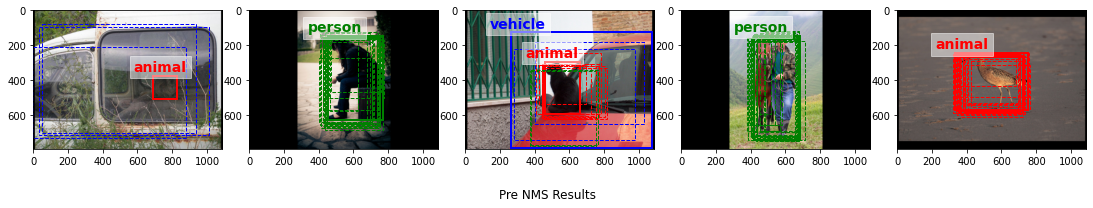

In [ ]:
keep_topK = 200 #For training
softmax = nn.Softmax()

annotations = ["vehicle", "person", "animal"]
colors = ['b', 'g', 'r']
fig = plt.figure(figsize=(15, 5))

num_plots = 5

with torch.no_grad():
    for iter, test_data in enumerate(train_loader):
        images = test_data[0].to(device)
        labels = test_data[1]
        bbox = test_data[3]

        backout = backbone(images.float())
        im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
        rpnout = rpn(im_lis, backout)

        proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]
        fpn_feat_list= list(backout.values())

        feature_vectors = model.MultiScaleRoiAlign(fpn_feat_list, proposals)

        class_logits, box_pred = model.forward(feature_vectors.detach())
        class_logits = softmax(class_logits)

        prenms_boxes, prenms_scores, prenms_labels, boxes_nms, scores_nms, labels_nms = model.postprocess_detections(model, class_logits, box_pred, proposals, keep_num_preNMS=50)

        ax = fig.add_subplot(1, num_plots, iter+1)
        ax.imshow(images[0].to('cpu').permute(1, 2, 0))

        for sample in range(len(labels)):
            box = bbox[sample]
            label = labels[sample]
            for obj in range(len(label)):            
                rect=patches.Rectangle((box[obj][0], box[obj][1]),
                                        box[obj][2]-box[obj][0],
                                        box[obj][3]-box[obj][1],
                                        fill=False, color=colors[int(label[obj] - 1)], linewidth=2.0)
                ax.add_patch(rect)
                ax.annotate(annotations[int(label[obj]) - 1], (box[obj][0] + 40, box[obj][1] - 50), color=colors[int(label[obj] - 1)], weight='bold', 
                        fontsize=14, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, edgecolor="white"))

        for c, l in zip(prenms_boxes[0], prenms_labels[0]):
            rect=patches.Rectangle((c[0], c[1]), c[2]-c[0], c[3]-c[1], fill=False, color=colors[int(l - 1)], linestyle='--')
            ax.add_patch(rect)

        if iter == num_plots-1:
            break

    plt.suptitle('Pre NMS Results', y=0.2)
    plt.tight_layout(pad=0)
    plt.show()




# 4. Mean Average Precision

In [ ]:
def compute_map(pred_regr, pred_scores, pred_clss, labels, bboxes):
    batch_size = len(labels)

    matches = []
    scores = []

    class_trues = torch.zeros(1, 3)
    class_true_positives = torch.zeros(1, 3)

    # Compute Matches, Scores, True and True Positives over batch of inputs
    for sample in range(batch_size):
        gt_proposals = len(labels[sample])
        num_pred = len(pred_clss[sample])

        match = torch.zeros(num_pred, 3)
        score = torch.zeros(num_pred, 3)

        # Compute classwise Matches, Scores, True and True Positives
        for i, cls in enumerate(pred_clss[sample]):
            cls = int(cls)
            cls_idx = int(cls - 1)

            if cls_idx in labels[sample]:
                gt_labels = (torch.from_numpy(labels[sample]) == cls).nonzero(as_tuple=False).squeeze(0)

                # Compute IOU between predicted and gt bbox
                for lab in gt_labels:
                    bbox_pred = torch.from_numpy(pred_regr[sample][i])
                    bbox_gt = torch.from_numpy(bboxes[sample][lab.item()-1])

                    x1 = max(bbox_pred[0], bbox_gt[0])
                    y1 = max(bbox_pred[1], bbox_gt[1])
                    x2 = min(bbox_pred[2], bbox_gt[2])
                    y2 = min(bbox_pred[3], bbox_gt[3])

                    box1 = (bbox_pred[2] - bbox_pred[0]) * (bbox_pred[3] - bbox_pred[1])
                    box2 = (bbox_gt[2] - bbox_gt[0]) * (bbox_gt[3] - bbox_gt[1])

                    intersection = max((x2 - x1), 0) * max((y2 - y1), 0)
                    union = box1 + box2 - intersection + 1e-15
                    
                    iou = intersection / union

                    #check
                    if iou > 0.5:
                        match[i, cls_idx] = 1

            score[i, cls-1] = float(pred_scores[sample][int(i)])

        # Compute True and True Positives
        trues_sample = torch.zeros(1, 3)
        true_positive_sample = torch.zeros(1, 3)
        for times in range(3):
            count_true = sum(torch.from_numpy(labels[sample]) == times + 1)
            count_pos = sum(torch.from_numpy(pred_clss[sample]) == times + 1)

            trues_sample[0, times] =  count_true
            true_positive_sample[0, times] =  1

        matches.append(match)
        scores.append(score)

        class_trues = torch.cat([class_trues, trues_sample], dim=0)
        class_true_positives = torch.cat([class_true_positives, true_positive_sample], dim=0)

    # Compute AP and MAP
    class_precision = []
    class_recall = []
    avg_prec = []

    match_cls = torch.cat(matches)
    score_cls = torch.cat(scores)

    tt = torch.sum(class_trues, dim=0)
    tp =  torch.sum(class_true_positives, dim=0)

    for cls_idx in range(3):
        max_score = torch.max(score_cls[:, cls_idx]).item()
        precision_cls = torch.empty(101)
        recall_cls = torch.zeros(101)
        
        ln = torch.linspace(0.2, max_score, steps=100)

        for i, th in enumerate(ln):
            matches = match_cls[:, cls_idx][score_cls[:, cls_idx] > th]
            true_positives = torch.sum(matches)
            precision = 1
            if tp[cls_idx] > 0:
                precision = true_positives / tp[cls_idx]

            recall = 1
            if tt[cls_idx] > 0:
                recall = true_positives / tt[cls_idx]

            precision_cls[i] = precision
            recall_cls[i] = recall

        recall_cls[100] = 0
        precision_cls[100] = 1

        sorted_idx = torch.argsort(recall_cls)
        sorted_recall = recall_cls[sorted_idx]
        sorted_precision = precision_cls[sorted_idx]

        area = auc(sorted_recall, sorted_precision)
        avg_prec.append(area)
        map = sum(avg_prec)/3

    return map, avg_prec[0], avg_prec[1], avg_prec[2]

In [ ]:
keep_topK = 200 #For training
softmax = nn.Softmax()

annotations = ["vehicle", "person", "animal"]
colors = ['b', 'g', 'r']
fig = plt.figure(figsize=(15, 10))

num_plots = 5

avg_vehicle_dataset = 0
avg_person_dataset = 0
avg_animal_dataset = 0
map_dataset = 0

with torch.no_grad():
    for iter, test_data in enumerate(train_loader):
        images = test_data[0].to(device)
        labels = test_data[1]
        bbox = test_data[3]

        backout = backbone(images.float())
        im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
        rpnout = rpn(im_lis, backout)

        proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]
        fpn_feat_list= list(backout.values())

        feature_vectors = model.MultiScaleRoiAlign(fpn_feat_list, proposals)

        class_logits, box_pred = model.forward(feature_vectors.detach())
        class_logits = softmax(class_logits)

        prenms_boxes, prenms_scores, prenms_labels, boxes_nms, scores_nms, labels_nms = model.postprocess_detections(model, class_logits, box_pred, proposals)
        map, avg_vehicle, avg_person, avg_animal = compute_map(boxes_nms, scores_nms, labels_nms, labels, bbox)

        avg_vehicle_dataset += avg_vehicle
        avg_person_dataset += avg_person
        avg_animal_dataset += avg_animal
        map_dataset += map
        
    print('Average Precision for Vehicle Class: ', avg_vehicle_dataset)
    print('Average Precision for Person Class: ', avg_person_dataset)
    print('Average Precision for Animal Class: ', avg_animal_dataset)

    print('Mean Average Precision: ', map_dataset)

Average Precision for Vehicle Class:  0.49238231
Average Precision for Person Class:  0.41640173
Average Precision for Animal Class:  0.38598434

Mean Average Precision:  0.43158946


# 5. Final Results

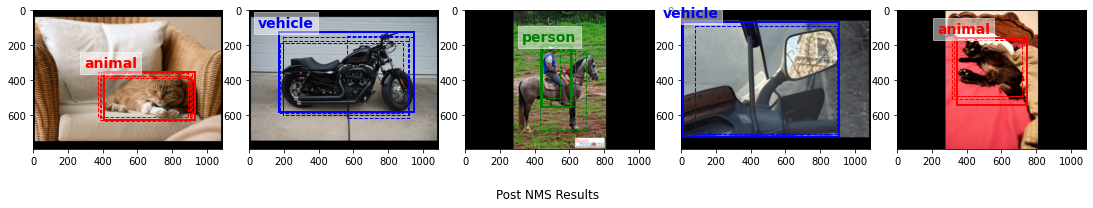

In [ ]:
keep_topK = 200 #For training
softmax = nn.Softmax()

annotations = ["vehicle", "person", "animal"]
colors = ['b', 'g', 'r']
fig = plt.figure(figsize=(15, 5))

num_plots = 5

with torch.no_grad():
    for iter, test_data in enumerate(train_loader):
        images = test_data[0].to(device)
        labels = test_data[1]
        bbox = test_data[3]

        backout = backbone(images.float())
        im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
        rpnout = rpn(im_lis, backout)

        proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]
        fpn_feat_list= list(backout.values())

        feature_vectors = model.MultiScaleRoiAlign(fpn_feat_list, proposals)

        class_logits, box_pred = model.forward(feature_vectors.detach())
        class_logits = softmax(class_logits)

        prenms_boxes, prenms_scores, prenms_labels, boxes_nms, scores_nms, labels_nms = model.postprocess_detections(model, class_logits, box_pred, proposals, keep_num_preNMS=50)

        ax = fig.add_subplot(1, num_plots, iter+1)
        ax.imshow(images[0].to('cpu').permute(1, 2, 0))

        for sample in range(len(labels)):
            box = bbox[sample]
            label = labels[sample]
            for obj in range(len(label)):            
                rect=patches.Rectangle((box[obj][0], box[obj][1]),
                                        box[obj][2]-box[obj][0],
                                        box[obj][3]-box[obj][1],
                                        fill=False, color=colors[int(label[obj] - 1)], linewidth=2.0)
                ax.add_patch(rect)
                ax.annotate(annotations[int(label[obj]) - 1], (box[obj][0] + 40, box[obj][1] - 50), color=colors[int(label[obj] - 1)], weight='bold', 
                        fontsize=14, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, edgecolor="white"))

        for c, l in zip(boxes_nms[0], labels_nms[0]):
            rect=patches.Rectangle((c[0], c[1]), c[2]-c[0], c[3]-c[1], fill=False, color=colors[int(l - 1)], linestyle='--')
            ax.add_patch(rect)

        if iter == num_plots-1:
            break

    plt.suptitle('Post NMS Results', y=0.2)
    plt.tight_layout(pad=0)
    plt.show()